# Image Captioning using Attention Mechanism

In this project, I will develop an Image Captioning model that leverages an Attention mechanism to generate descriptive captions for images. The model's architecture will consist of two main components:

- Encoder: This component utilizes a Convolutional Neural Network (CNN) to extract high-level features from input images. The CNN will process the image and produce a set of feature maps that capture essential visual information.

- Decoder: The Decoder, implemented as a Recurrent Neural Network (RNN), will use the feature maps from the Encoder to generate descriptive captions. An Attention mechanism will be incorporated to enable the model to focus on different parts of the image while generating each word in the caption, thereby improving the quality and relevance of the generated text.

By integrating these components, the model aims to provide accurate and contextually rich descriptions for a variety of images.

First, import all the necessary dependencies.

In [1]:
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

import torch
import torchtext; torchtext.disable_torchtext_deprecation_warning()
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
from collections import Counter

from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

Extracting the dataset

In [2]:
def extract_zip(zip_path, extract_to_folder):
    """
    Extracts a zip file to a specific folder.

    Parameters:
    zip_path (str): Path to zip file
    extract_to_folder (str): Directory where the ZIP file should be extracted
    """
    # Create the destination directory if it does not exist
    os.makedirs(extract_to_folder, exist_ok = True)

    try:
        # Opening the zip file
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            # Extracting all the contents into a specifies folder
            zip_ref.extractall(extract_to_folder)
        print(f"ZIP file extracted successfully to {extract_to_folder}.")

    except FileNotFoundError:
        print(f"Error: The file {zip_path} does not exist.")

    except zipfile.BadZipFile:
        print(f"Error: The file {zip_path} is not a ZIP file or it is corrupted.")

    except Exception as e:
        print(f"An unexcepted error occurred: {e}")

In [3]:
# Path for the Zip file and Path for the Directory
zip_path = "Data/datasets/flickr8k.zip"
extract_to_folder = "Data"

In [4]:
# Extract the ZIP file
extract_zip(zip_path, extract_to_folder)

ZIP file extracted successfully to Data.


In [5]:
# Calling the Captions dataset
image_captions = pd.read_csv("Data/captions.txt")

# First 5 rows of the Captions dataset
image_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
print(f"Shape of the Captions Dataset: {image_captions.shape}")

Shape of the Captions Dataset: (40455, 2)


In [7]:
# Switching to "cuda", if not then use "cpu" only.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Device currently in use: {device}")

Device currently in use: cpu


Initializing the Tokenizer from the "torchtext" library and setting up the Counter.

In [8]:
tokenizer = get_tokenizer("basic_english")
counter = Counter()

We will construct the vocabulary for the image captions using the torchtext library. This step involves processing the text data to create a comprehensive vocabulary that the model will use to understand and generate descriptive captions for the images.

In [9]:
for line in image_captions["caption"].tolist():
    counter.update(tokenizer(line))

vocab = vocab(counter, min_freq = 5)

In this step, we enhance our vocabulary by adding special tokens that play a crucial role in the caption generation process. We insert tokens for 
- padding (pad), 
- the start of a caption (start), 
- the end of a caption (end),
- unknown words (unk). 

These tokens are assigned specific indices to standardize their positions within the vocabulary.

In [10]:
# Defining the special tokens
unk_token = "<unk>"
pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"

# Inserting the special tokens at certain locations
vocab.insert_token(unk_token, 0)
vocab.insert_token(pad_token, 1)
vocab.insert_token(sos_token, 2)
vocab.insert_token(eos_token, 3)

# Setting the default index for unknown words to the index of the unknown token.
vocab.set_default_index(vocab["<unk>"])

This step involves defining a custom dataset class for the Image Captioning model. The dataset class is responsible for loading images and their corresponding captions, tokenizing the captions, and converting them to integer token IDs. The "__getitem__" method retrieves an image and its caption, applies any specified transformations to the image, and processes the caption to include special tokens such as sos and eos. The method returns the processed image and the tokenized caption, which are then used for training the model.

In [11]:
class FlickrDataset(Dataset):

    def __init__(self, 
                 root_dir, 
                 caption_file, 
                 vocab, 
                 transform = None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab

        df = pd.read_csv(caption_file)

        self.length = len(df)

        self.captions = df["caption"]
        self.image_names = df["image"]

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.image_names[idx]

        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
        
        caption_text_to_index = lambda x: [self.vocab[token] for token in tokenizer(x)]

        caption_vec = []
        caption_vec += [vocab["<sos>"]]
        caption_vec += caption_text_to_index(caption)
        caption_vec += [vocab["<eos>"]]

        return img, torch.tensor(caption_vec)

In [12]:
class GenerateBatchCaption:
    def __init__(self, 
                 pad_idx, 
                 batch_first = False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]

        imgs = torch.cat(imgs, dim = 0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = self.batch_first, padding_value = self.pad_idx)

        return imgs, targets

In [13]:
def display_image(input_img, title = "Image"):

    # Normalizing the image by the values of mean and std dev of  the ResNet model 
    input_img[0] = input_img[0] * 0.229
    input_img[1] = input_img[1] * 0.224 
    input_img[2] = input_img[2] * 0.225 

    input_img[0] += 0.485 
    input_img[1] += 0.456 
    input_img[2] += 0.406

    input_img = input_img.numpy().transpose((1, 2, 0))
    plt.imshow(input_img)
    plt.title(title)

    plt.pause(0.001)

To prepare the images for the model, we define a set of transformations that include resizing, random cropping, conversion to a tensor, and normalization. These transformations help in standardizing the input images and augmenting the dataset.

In [14]:
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

flickr_dataset = FlickrDataset(
    root_dir = "Data/images",
    caption_file = "Data/captions.txt",
    vocab = vocab,
    transform = transforms
)

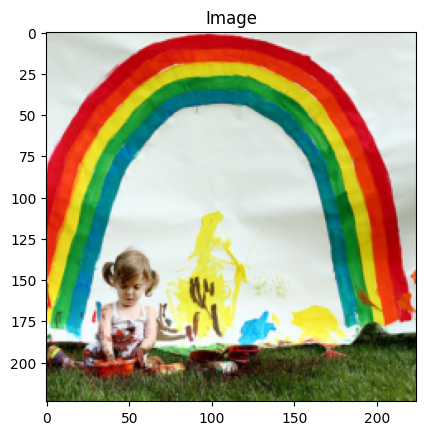

Token_ids: tensor([ 2,  4, 65, 18,  6, 25, 66, 67, 36,  0,  6, 58, 13,  4, 41, 68, 36,  4,
        60, 39, 69, 17,  3])
caption: 
['<sos>', 'a', 'small', 'girl', 'in', 'the', 'grass', 'plays', 'with', '<unk>', 'in', 'front', 'of', 'a', 'white', 'canvas', 'with', 'a', 'rainbow', 'on', 'it', '.', '<eos>']


In [15]:
img, ids = flickr_dataset[12]
display_image(img)
print(f"Token_ids: {ids}")
print(f"caption: ")
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

A DataLoader is used to efficiently load data in batches, shuffle the dataset, and handle parallel processing. This is particularly useful for training deep learning models.

In [17]:
batch_size = 128

pad_idx = vocab["<pad>"]

data_loader = DataLoader(
    dataset = flickr_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = GenerateBatchCaption(pad_idx = pad_idx, batch_first = True)
)

In [18]:
resnet = models.resnet50()

print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)

        batch, feature_maps, size_1, size_2 = features.size()

        features = features.permute(0, 2, 3, 1)

        features = features.view(batch, -1, feature_maps)

        return features